In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.integrate import simps
from numpy import trapz

from angstrom import Molecule
from thermof.read import read_log, read_thermo
from wham import *
from dctst import *

%matplotlib inline

## WHAM 1-D
This notebook is for WHAM analysis in 1D

#### Surface scan parameters

In [4]:
SCAN = 'HtBDC_Cu110'
SCANDIR = '/home/kutay/Documents/git/Nanocar/surface-scan'
DATADIR = os.path.join(SCANDIR, 'analysis', 'data')
WHAMDIR = os.path.join(SCANDIR, 'analysis', 'wham', 'run')

In [5]:
SCANLIST = sorted([int(i) for i in os.listdir(os.path.join(WHAMDIR, SCAN))])
DATA = {}
for scanidx in SCANLIST:
    wham_out = os.path.join(WHAMDIR, SCAN, str(scanidx), '%i.out' % scanidx)
    wham_data = read_wham_out(wham_out)
    # Get activation energy
    F = np.array(wham_data['free'])
    F[np.isinf(F)] = 0
    wham_data['Ea'] = max(F)
    DATA[scanidx] = wham_data

### Calculate Boltzmann average activation energy

In [6]:
F = [DATA[i]['Ea'] for i in DATA]
F_avg = calculate_boltzmann_average(F, temperature=200)
F_min_idx = np.argsort(F)[0]
F_min = F[F_min_idx]
print('Min Ea: %.3f | Avg. Ea: %.3f' % (F_min, F_avg))

Min Ea: 4.124 | Avg. Ea: 4.150


### Fit gaussian curve and also pick lowest energy barrier

$F(q) = e^{-a ( \frac{\Delta x}{2} - x)^2 + b}$


E_WHAM: 4.124 | E_GAUSS: 4.482 | b_direction: -1
Found b value: 1.42 with dE: 0.054 within tolerance in 7 iterations
Finished fitting. 7 iterations | dE: 0.054 | b_final: 1.42
WHAM Area: 7.49 | F(q*): 4.12
GAUSS Area: 5.18 | F(q*): 4.14


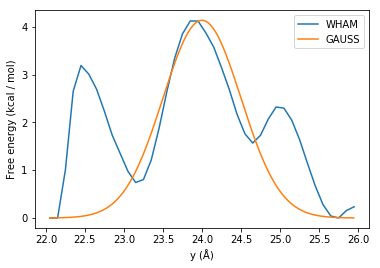

In [7]:
x_wham = np.array(DATA[F_min_idx]['coor'])
f_wham = np.array(DATA[F_min_idx]['free'])
f_wham[np.isinf(f_wham)] = 0
area_wham = simps(f_wham, dx=0.1)

x_gauss, f_gauss = fit_gaussian(x_wham, f_wham, dx=0.005)
area_gauss = simps(f_gauss, dx=0.005)

plt.plot(x_wham, f_wham)
plt.plot(x_gauss, f_gauss)
plt.ylabel('Free energy (kcal / mol)')
plt.xlabel('y (Å)')
plt.legend(['WHAM', 'GAUSS'])

print('WHAM Area: %.2f | F(q*): %.2f' % (area_wham, max(f_wham)))
print('GAUSS Area: %.2f | F(q*): %.2f' % (area_gauss, max(f_gauss)))

### Calculate rate and diffusion coefficient

$k_{A \rightarrow B} = \kappa {\sqrt{ \dfrac{1}{2 \pi M \beta}}} \dfrac{ e^{- \beta F(q^*)} } { \int e^{- \beta F(q)}dq } \ \ \rightarrow \ \  k_{A \rightarrow B} = \kappa \times 36.377 \sqrt{\dfrac{T}{M}} \dfrac{ e^{- \beta F(q^*)} } { \int e^{- \beta F(q)}dq }  \Big(\dfrac{1}{s}\Big)$

$D_s = \dfrac{1}{2n} \times k_{A \rightarrow B} \times \lambda^2$

In [77]:
mol = Molecule(read='/home/kutay/Documents/git/Nanocar/molecules/surface-diffusion/opt/%s.xyz' % SCAN.split('_')[0])
mw = mol.get_molecular_weight()       # g / mol

In [82]:
k_WHAM = calculate_rate(max(F_WHAM), area_wham, mw)
D_WHAM = calculate_diffusion(k_WHAM, lamda=1)
print('k: %.2e 1/s | D: %.2e cm2/s' % (k_WHAM, D_WHAM))

k: 6.04e+00 1/s | D: 2.31e-15 cm2/s


In [83]:
k_GAUSS = calculate_rate(max(F_GAUSS), area_gauss, mw)
D_GAUSS = calculate_diffusion(k_GAUSS, lamda=1)
print('k: %.2e 1/s | D: %.2e cm2/s' % (k_GAUSS, D_GAUSS))

k: 1.46e+01 1/s | D: 5.59e-15 cm2/s


## Read all SCANs

In [6]:
ALL_DATA = {}
for SCAN in os.listdir(DATADIR):
    SCANLIST = sorted([int(i) for i in os.listdir(os.path.join(WHAMDIR, SCAN))])
    DATA = {}
    for scanidx in SCANLIST:
        wham_out = os.path.join(WHAMDIR, SCAN, str(scanidx), '%i.out' % scanidx)
        wham_data = read_wham_out(wham_out)
        # Get activation energy
        f_scan = np.array(wham_data['free'])
        f_scan[np.isinf(f_scan)] = 0
        wham_data['Ea'] = max(f_scan)
        DATA[scanidx] = wham_data
    F = [DATA[i]['Ea'] for i in DATA]
    F_avg = calculate_boltzmann_average(F, temperature=200)
    F_min_idx = np.argsort(F)[0]
    F_min = F[F_min_idx]
    
    # Calculate molecular weight
    mol = Molecule(read='/home/kutay/Documents/git/Nanocar/molecules/surface-diffusion/opt/%s.xyz' % SCAN.split('_')[0])
    mw = mol.get_molecular_weight()
    
    # Calculate k and D using WHAM barrier
    x_wham = np.array(DATA[F_min_idx]['coor'])
    f_wham = np.array(DATA[F_min_idx]['free'])
    f_wham[np.isinf(f_wham)] = 0
    area_wham = simps(f_wham, dx=0.1)
    k_wham = calculate_rate(max(f_wham), area_wham, mw)
    d_wham = calculate_diffusion(k_wham, lamda=1)

    # Calculate k and D using Gaussian fit
    x_gauss, f_gauss = fit_gaussian(x_wham, f_wham, dx=0.005, tolerance=0.01)
    area_gauss = simps(f_gauss, dx=0.005)
    k_gauss = calculate_rate(max(f_gauss), area_gauss, mw)
    d_gauss = calculate_diffusion(k_gauss, lamda=1)
    
    ALL_DATA[SCAN] = {'f_star_w': max(f_wham), 'f_area_w': area_wham, 'x_w': x_wham, 'f_w': f_wham, 'k_w': k_wham, 'd_w': d_wham, 'mw': mw,
                      'f_star_g': max(f_gauss), 'f_area_g': area_gauss, 'x_g': x_gauss, 'f_g': f_gauss, 'k_g': k_gauss, 'd_g': d_gauss}

E_WHAM: 3.500 | E_GAUSS: 4.482 | b_direction: -1
Found b value: 1.25 with dE: 0.025 within tolerance in 24 iterations
Finished fitting. 24 iterations | dE: 0.025 | b_final: 1.25
E_WHAM: 3.087 | E_GAUSS: 4.482 | b_direction: -1
Found b value: 1.13 with dE: 0.040 within tolerance in 36 iterations
Finished fitting. 36 iterations | dE: 0.040 | b_final: 1.13
E_WHAM: 5.569 | E_GAUSS: 4.482 | b_direction: 1
Finished fitting. 999 iterations | dE: 0.015 | b_final: 11.50
E_WHAM: 5.439 | E_GAUSS: 4.482 | b_direction: 1
Finished fitting. 999 iterations | dE: 0.020 | b_final: 11.50
E_WHAM: 4.124 | E_GAUSS: 4.482 | b_direction: -1
Finished fitting. 999 iterations | dE: 0.013 | b_final: -8.50
E_WHAM: 6.413 | E_GAUSS: 4.482 | b_direction: 1
Finished fitting. 999 iterations | dE: 0.010 | b_final: 11.50
E_WHAM: 1.708 | E_GAUSS: 4.482 | b_direction: -1
Found b value: 0.54 with dE: 0.025 within tolerance in 95 iterations
Finished fitting. 95 iterations | dE: 0.025 | b_final: 0.54
E_WHAM: 2.500 | E_GAUSS: 

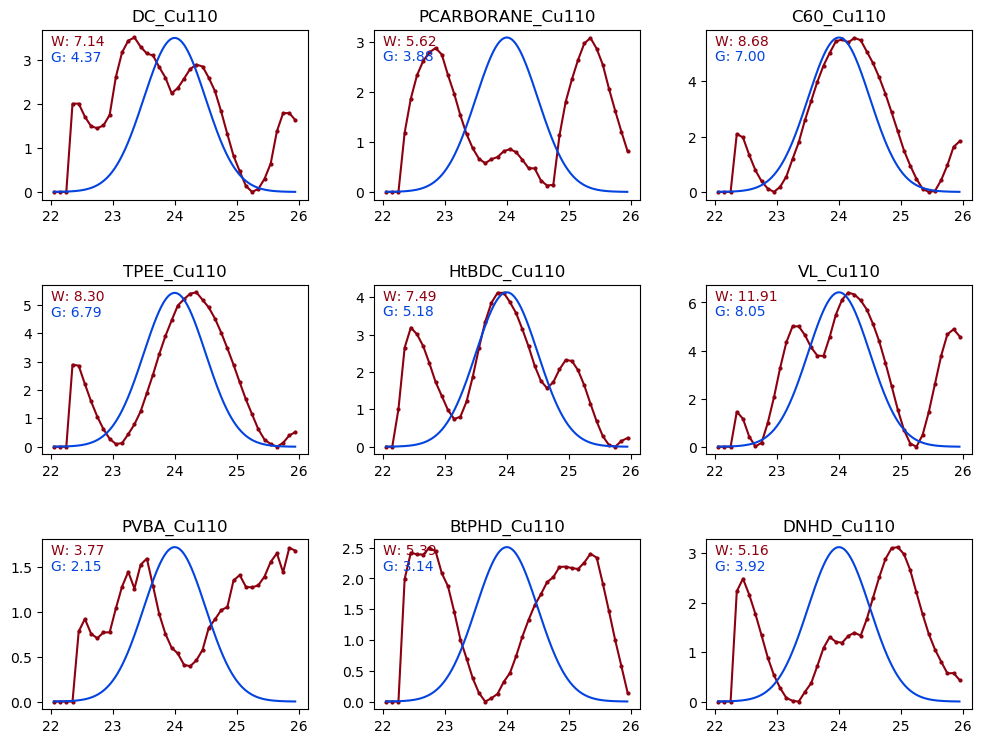

In [29]:
fig = plt.figure(figsize=(12, 9), dpi=100)
fig.subplots_adjust(hspace=.5, wspace=.25)

for i, scan in enumerate(ALL_DATA, start=1):
    ax = fig.add_subplot(3, 3, i)
    ax.plot(ALL_DATA[scan]['x_w'], ALL_DATA[scan]['f_w'], '-o', c='xkcd:crimson', lw=1.5, markersize=2)
    ax.plot(ALL_DATA[scan]['x_g'], ALL_DATA[scan]['f_g'], '-', c='xkcd:blue', lw=1.5, markersize=2)
    ax.text(22, max(ALL_DATA[scan]['f_g']) * 0.95, 'W: %.2f' % ALL_DATA[scan]['f_area_w'], color='xkcd:crimson')
    ax.text(22, max(ALL_DATA[scan]['f_g']) * 0.85, 'G: %.2f' % ALL_DATA[scan]['f_area_g'], color='xkcd:blue')
    ax.set_title('%s' % scan)

### Molecular weight vs diffusion
This plot sort of proves that Gaussian fit doesn't really capture the effect of geometry.
Some molecules can break the MW vs D curve by geometry due to having differently shaped energy barriers.
With Gaussian fit since the barrier shape is the same for all these differences are not pronounced.

In [19]:
mw_all = [ALL_DATA[i]['mw'] for i in ALL_DATA]
mw_order = np.argsort(mw_all)
d_w_all = [ALL_DATA[i]['d_w'] for i in ALL_DATA]
d_g_all = [ALL_DATA[i]['d_g'] for i in ALL_DATA]

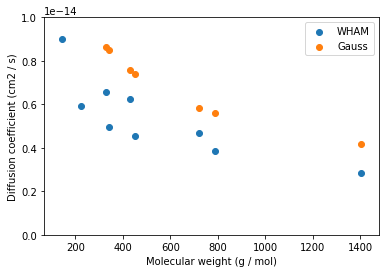

In [28]:
plt.scatter(mw_all, d_w_all)
plt.scatter(mw_all, d_g_all)
plt.ylim(0, 1e-14)
plt.ylabel('Diffusion coefficient (cm2 / s)')
plt.xlabel('Molecular weight (g / mol)')
plt.legend(['WHAM', 'Gauss'])